In [1]:
import glob, os, sys, vcf
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import statsmodels.api as sm
from statsmodels.tools.tools import pinv_extended  

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.dpi"] = 150
import scipy.stats as st

from scipy.spatial.distance import pdist, squareform

# Compute genetic distance matrices

1. For all sequences
2. Between Bangladesh sequences only

In [85]:
# contains isolate MK575063, which has the premature stop codon
#P_seqs = [(seq.id, str(seq.seq)) for seq in SeqIO.parse("seq_for_analysis/P_unique_HeV.fasta", "fasta")]
P_seqs = [(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/PG/P_seqs.fasta", "fasta")]

P_seq_df = pd.DataFrame(P_seqs)
P_seq_df.columns = ["ID", "Seq"]

# remove Hendra virus sequence too
#P_seq_df = P_seq_df.loc[(~P_seq_df["Seq"].str.contains("N")) & (P_seq_df["ID"] != "JN255817")].reset_index(drop=True)
P_seq_df = P_seq_df.loc[(P_seq_df["ID"] != "JN255817")].reset_index(drop=True)

print(P_seq_df.shape)

lengths = [len(seq) for seq in P_seq_df["Seq"]]
print(np.unique(lengths))

metadata = pd.read_csv("metadata_all.csv")

for i, row in P_seq_df.loc[P_seq_df.Seq.str.contains("N")].iterrows():
    
    if len(np.where(np.array(list(row["Seq"]))=="N")[0]) / len(row["Seq"]) > 0.01:
        print(f"Removed {row['ID']}")
        P_seq_df = P_seq_df.drop(i)
        
print(P_seq_df.shape)

(81, 2)
[2130]
Removed MH891774
Removed MK673586
(79, 2)


In [86]:
seq_mat = P_seq_df["Seq"].str.split("", expand=True).iloc[:, 1:-1]
seq_mat.columns = np.arange(len(P_seq_df.Seq.values[0]))+1
seq_mat["ID"] = P_seq_df.ID
seq_mat = seq_mat.set_index("ID")

In [231]:
# no indels in these sequences, all are same length
NUM_TO_BASE = {0:"A", 1:"C", 2:"G", 3:"T", 4:"N"}
BASE_TO_NUM = {}

for key, val in NUM_TO_BASE.items():
    BASE_TO_NUM[val] = key

In [232]:
seq_mat = seq_mat.replace(BASE_TO_NUM)
similarity_mat = 1 - squareform(pdist(seq_mat, metric="hamming"))

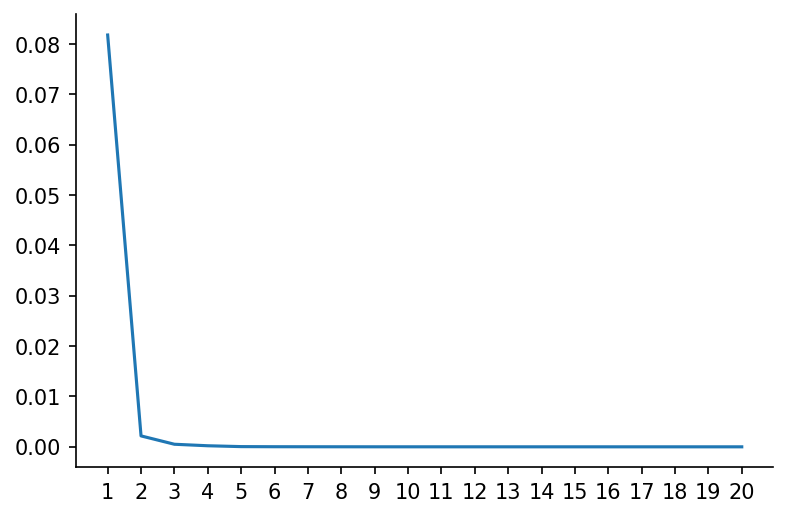

In [233]:
pca = PCA(20)
pca.fit(similarity_mat)

plt.plot(np.arange(20)+1, pca.explained_variance_)
sns.despine()
plt.xticks(np.arange(20)+1)
plt.show()

## Super tight clustering compared to distances between clusters

## Quantify that magnitude difference!!

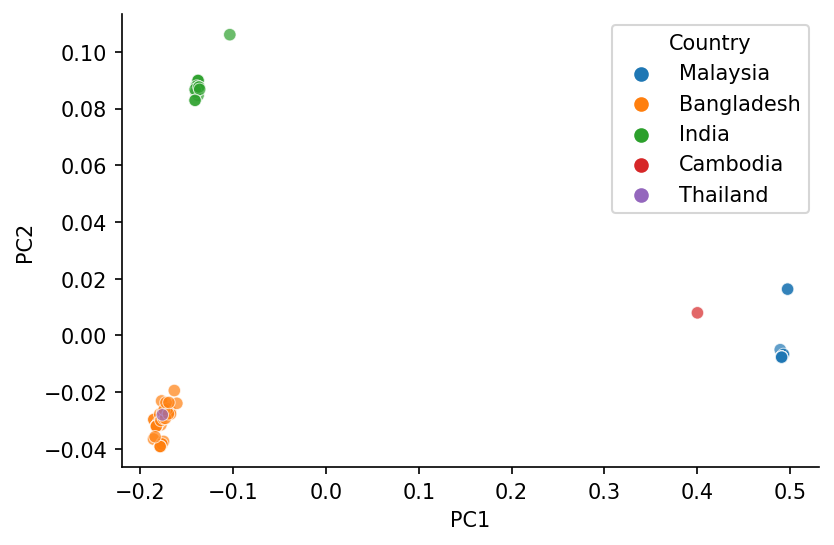

In [234]:
pca = PCA(2)
x_trans = pca.fit_transform(similarity_mat)

x_trans_df = pd.DataFrame(x_trans)
x_trans_df.columns = ["PC1", "PC2"]
x_trans_df["ID"] = seq_mat.index
x_trans_df = x_trans_df.merge(metadata, on="ID")

# the India sequence FJ513078 is in the Bangladesh cluster, just not visible, but checked the coordinates
sns.scatterplot(data=x_trans_df, x="PC1", y="PC2", hue="Country", alpha=0.7)
sns.despine()
plt.show()

In [235]:
similarity_mat.shape

(79, 79)

In [236]:
mys_mat = similarity_mat[x_trans_df.query("Country in ['Malaysia', 'Cambodia']").index, :][:, x_trans_df.query("Country in ['Malaysia', 'Cambodia']").index]
bgd_mat = similarity_mat[x_trans_df.query("Country in ['Bangladesh', 'Thailand']").index, :][:, x_trans_df.query("Country in ['Bangladesh', 'Thailand']").index]
india_mat = similarity_mat[x_trans_df.query("Country == 'India'").index, :][:, x_trans_df.query("Country == 'India'").index]

In [237]:
mys_vals = mys_mat[np.triu_indices(mys_mat.shape[0], k=1)]
india_vals = india_mat[np.triu_indices(india_mat.shape[0], k=1)]
bgd_vals = bgd_mat[np.triu_indices(bgd_mat.shape[0], k=1)]

df_sim_mat = pd.DataFrame({"Sim": np.concatenate([mys_vals, india_vals, bgd_vals]),
                           "Country": ["Malaysia"]*len(mys_vals) + ["India"]*len(india_vals) + ["Bangladesh"]*len(bgd_vals)
                          })

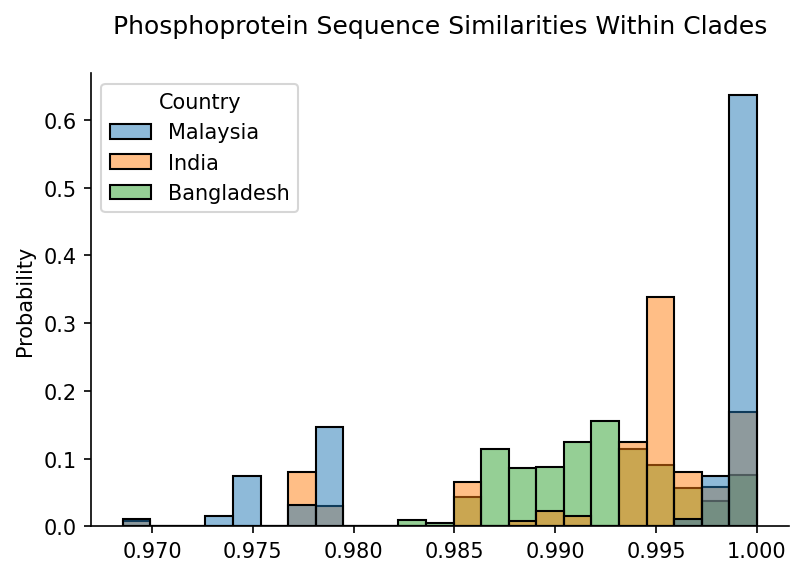

In [238]:
sns.histplot(data=df_sim_mat, x="Sim", hue="Country", common_norm=False, stat="probability", element="bars", kde=False,
            multiple="layer")

plt.title("Phosphoprotein Sequence Similarities Within Clades\n")
plt.xlabel("")
sns.despine()
plt.show()

In [239]:
# fig, ax = plt.subplots()

# ax.scatter(y=3, x=np.mean(mys_vals), label="Malaysia")
# ax.errorbar(y=[3]*len(mys_vals), x=mys_vals)

# ax.scatter(y=2, x=np.mean(india_vals), label="India")
# ax.errorbar(y=[2]*len(india_vals), x=india_vals)

# ax.scatter(y=1, x=np.mean(bgd_vals), label="Bangladesh")
# ax.errorbar(y=[1]*len(bgd_vals), x=bgd_vals)

# sns.despine()
# plt.show()

In [240]:
between_clade_diffs = np.concatenate([
    #similarity_mat[:, x_trans_df.query("Country in ['Bangladesh', 'Thailand']").index][x_trans_df.query("Country in ['Malaysia', 'Cambodia']").index, :].flatten(),
                                      #similarity_mat[:, x_trans_df.query("Country in ['India']").index][x_trans_df.query("Country in ['Malaysia', 'Cambodia']").index, :].flatten(),
                                      similarity_mat[:, x_trans_df.query("Country in ['Bangladesh', 'Thailand']").index][x_trans_df.query("Country in ['India']").index, :].flatten()
                                    ])

between_clade_diffs.shape

(714,)

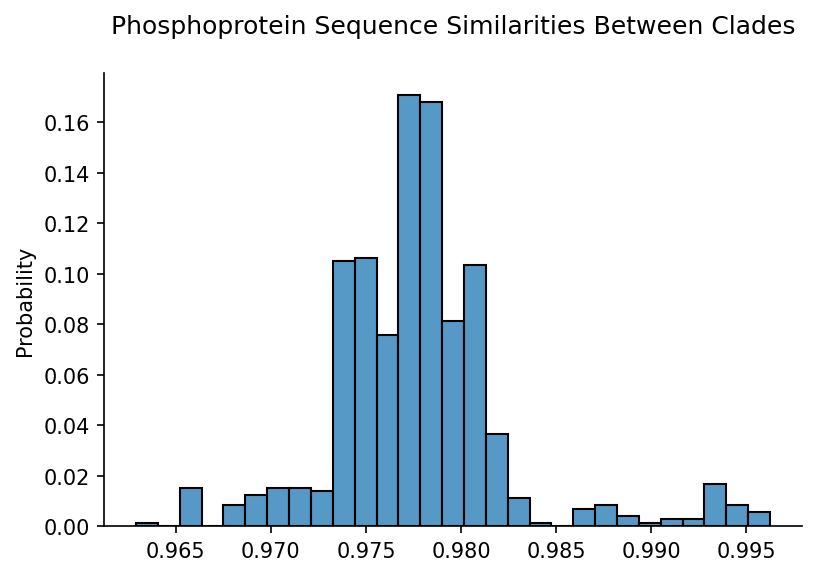

In [241]:
sns.histplot(between_clade_diffs, stat="probability")
sns.despine()
plt.title("Phosphoprotein Sequence Similarities Between Clades\n")

plt.show()

In [242]:
# flattened array of the upper triangular values, excluding the diagonal (which are all 1s)
# if you change k to 0, the 1s come back, so k=1 is correct.
unique_dist = similarity_mat[np.triu_indices(similarity_mat.shape[0], k=1)]

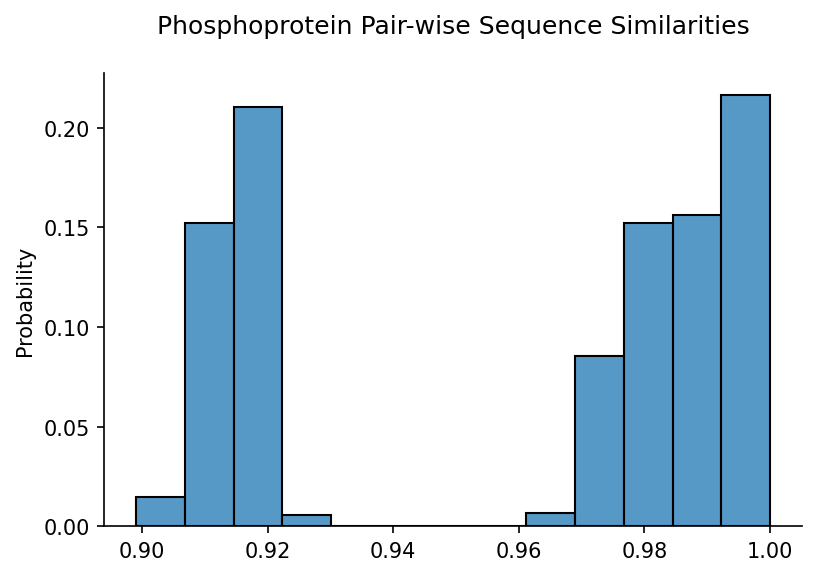

In [243]:
sns.histplot(unique_dist, stat="probability")
sns.despine()
plt.title("Phosphoprotein Pair-wise Sequence Similarities\n")

plt.show()

# Extracting and analyzing data from the VCF files

## Don't need to do any QC filtering because that's for reads from FASTQ files

## These are all post-QC sequences in FASTA files

```bash
bash snp_calling/call_snps.sh sequences/genome/NC_00278_MYS seq_for_analysis/P_seqs.fasta alignments P_for_linReg
```

In [244]:
# def get_seq_df(fasta_file):
    
#     seqs = [(seq.id, str(seq.seq)) for seq in SeqIO.parse(fasta_file, "fasta")]
#     seq_df = pd.DataFrame(seqs).rename(columns={0:"ID", 1:"Seq"})
    
#     data_transf = seq_df.Seq.str.split("", expand=True).iloc[:, 1:-1].T.reset_index()
#     data_transf.columns = ["Pos"] + list(seq_df.ID.values)
#     data_transf = data_transf.set_index("Pos")
    
#     # remove isolates in which more than 1% of nucleotides are missing
#     for isolate in data_transf.columns:

#         if len(np.where(data_transf[isolate]=="N")[0]) / len(data_transf) > 0.01:
#             print(f"Removed {isolate}")
#             del data_transf[isolate]
    
#     return data_transf

In [316]:
# same dictionaries as used above
# no indels in these sequences, all are same length
NUM_TO_BASE = {0:"A", 1:"C", 2:"G", 3:"T", 4:"N"}
BASE_TO_NUM = {}

for key, val in NUM_TO_BASE.items():
    BASE_TO_NUM[val] = key
    
# Get one hot vector
def get_one_hot(sequence):

    if not pd.isnull(sequence):
        seq_in_index = np.array([BASE_TO_COLUMN.get(b, b) for b in sequence])

        one_hot = np.zeros((len(sequence), 4))

        # only get the non N sites because otherwise we get indexing errors
        ind_non_gap = np.where(seq_in_index != 4)[0]

        # Assign the found positions to 1
        one_hot[ind_non_gap, seq_in_index[ind_non_gap]] = 1

        # flatten the array
        return one_hot.flatten()
    else:
        return np.nan
    
P_seq_df["seq_one_hot"] = P_seq_df.Seq.apply(get_one_hot)

In [317]:
get_one_hot("ACGT").flatten()

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])

In [318]:
P_seq_df["seq_one_hot"].values[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [345]:
X = P_seq_df["seq_one_hot"].values[0].reshape(1, len(P_seq_df["seq_one_hot"].values[0]))

for _, row in P_seq_df.iloc[1:, :].iterrows():
    X = np.concatenate([X, row["seq_one_hot"].reshape(1, len(row["seq_one_hot"]))], axis=0)
    
# outcome variable -- 1 for BGD clade, 0 for MYS clade. Imbalanced classes
y = P_seq_df.merge(metadata).Country.replace({"Bangladesh": 1, "India": 1, "Thailand": 1, "Malaysia": 0, "Cambodia": 0}).values

In [347]:
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [300]:
X.shape

(1000, 4)

In [297]:
pd.Series(y).value_counts()

1    59
0    20
dtype: int64

In [281]:
X.shape

(79, 2130, 4)

In [5]:
def create_snp_matrix(fasta_file, isolates_lst, vcf_file):
    
    seq_df = get_seq_df(fasta_file, isolates_lst)
    vcf_df = get_aln_snps(vcf_file)
    
    # search for only sites that have been flagged as having SNPs using the variant caller (using bcftools, done earlier)
    variants_seq_df = seq_df.loc[seq_df.Pos.isin(vcf_df.pos.values)]
    
    # iterate through the positions in the above dataframe
    for pos in variants_seq_df.Pos.values:
    
        # iterate through every isolate (columns)
        for col in variants_seq_df.columns[1:]:

            if variants_seq_df.loc[variants_seq_df.Pos == pos, col].values[0] == vcf_df.loc[vcf_df.pos == pos, "ref"].values[0]:
                variants_seq_df.loc[variants_seq_df.Pos == pos, col] = 0
            else:
                variants_seq_df.loc[variants_seq_df.Pos == pos, col] = 1
              
    # separate the sites
    sites = variants_seq_df.Pos.values
    del variants_seq_df["Pos"]
    
    variants_seq_df = variants_seq_df.T
    variants_seq_df.columns = sites
                
    return sites, variants_seq_df

In [6]:
metadata = pd.read_csv("metadata_all.csv")

isolates_for_model = metadata.query("G == 1 & P == 1 & Country in ['India', 'Bangladesh', 'Malaysia']").ID.values
len(isolates_for_model)

P_snp_sites, P_snp_matrix = create_snp_matrix("sequences/PG/P_seqs.fasta", isolates_for_model, "alignments/P_for_linReg_SNPs.vcf")
G_snp_sites, G_snp_matrix = create_snp_matrix("sequences/PG/G_seqs.fasta", isolates_for_model, "alignments/G_for_linReg_SNPs.vcf")

P_snp_matrix.columns = ["P" + str(col) for col in P_snp_matrix.columns]
G_snp_matrix.columns = ["G" + str(col) for col in G_snp_matrix.columns]

input_mat = pd.concat([P_snp_matrix, G_snp_matrix], axis=1)
input_mat = input_mat.astype(int)
snp_cols = input_mat.columns
isolates = input_mat.index

In [7]:
# check that it's in the same order
assert sum(metadata.query("ID in @isolates_for_model").ID.values != isolates_for_model) == 0

X_india_bgd = input_mat.loc[input_mat.index.isin(metadata.query("Country in ['Bangladesh', 'India']").ID.values)]

y_MB = metadata.query("ID in @isolates_for_model").Country.map({"Malaysia": 0, "India": 1, "Bangladesh": 1}).values
y_india_bgd = metadata.query("ID in @isolates_for_model").Country.map({"India": 0, "Bangladesh": 1}).dropna().values.astype(int)

#pd.DataFrame(y).rename(columns={0:"Y", 1:"I", 2:"B"}).to_csv("plsda_output.csv", index=False)

# recode with dummy variables (analogous to one-hot encoding)
#y = pd.get_dummies(y).values

In [8]:
X_india_bgd.shape, len(y_india_bgd)

((59, 183), 59)

In [9]:
input_mat.values.shape, len(y_MB)

((77, 183), 77)

# Next, encode every sequence in `P_whitmer` as a binary variable representing reference (0) or alternative (1) allele

# PCA of P and G sequences to look for clade clustering

## 1. PCA for all data to check separation by country 

In [8]:
def create_seq_df(metadata):

    # read in all fasta files

    P_all = pd.DataFrame([(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/PG/P_seqs.fasta", "fasta")]).rename(columns={0: "ID", 1:"P_seq"})
    G_all = pd.DataFrame([(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/PG/G_seqs.fasta", "fasta")]).rename(columns={0: "ID", 1:"G_seq"})

    P_unique = [seq.id for seq in SeqIO.parse("seq_for_analysis/P_deduplicated.fasta", "fasta")]
    G_unique = [seq.id for seq in SeqIO.parse("seq_for_analysis/G_deduplicated.fasta", "fasta")]
    
    seq_df = pd.merge(P_all, G_all, how="outer")
    
    # add variables for whether a sequence is part of the deduplicated sets (deduplication done randomly because metadata not significantly different to justify selecting a particular sequence)
    seq_df["P_dedup"] = seq_df["ID"].isin(P_unique).astype(int)
    seq_df["G_dedup"] = seq_df["ID"].isin(G_unique).astype(int)
    
    return seq_df.merge(metadata, on="ID", how="outer")

In [10]:
def pca_elbow(mat, n, scale=False):
     
    if scale:
        scaler = StandardScaler()
        mat = scaler.fit_transform(mat)
    
    pca = PCA(n)
    pca.fit(mat)
    
    plt.plot(np.arange(n)+1, pca.explained_variance_ratio_)
    plt.xticks(np.arange(n)+1)
    
    plt.xlabel("PC")
    plt.ylabel("Proportion of Variance Explained")
    sns.despine()
    plt.show()

In [11]:
# no need to use PCs of the GRM because we ARE looking for differences from population structure
# pca_elbow(np.cov(input_mat.values), 10)

In [12]:
def plot_PCA(snp_matrix, color_col, n_comp=2):
    '''
    Perform PCA using the SNP matrix
    '''
    
    ncbi_ids = snp_matrix.index.values
    
    scaler = StandardScaler()
    X = scaler.fit_transform(snp_matrix.values)
    
    pca_10 = PCA(n_components=10)
    pca_10.fit(X)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(np.arange(1, 11), pca_10.explained_variance_ratio_)
    
    pca = PCA(n_components=n_comp)
    X_new = pca.fit_transform(X)
    pca_df = pd.DataFrame(X_new).rename(columns=dict(zip(np.arange(n_comp), [f"PC{num}" for num in np.arange(n_comp)+1])))
    pca_df["ID"] = ncbi_ids
    
    sliced_metadata = metadata.loc[metadata.ID.isin(snp_matrix.index)]
    pca_df = pca_df.merge(sliced_metadata[["ID", "Country", "Clade"]], on="ID")
        
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=color_col, alpha=0.7, s=50, ax=ax[1])
    sns.despine()
    plt.show()
    
    return X, pca_df

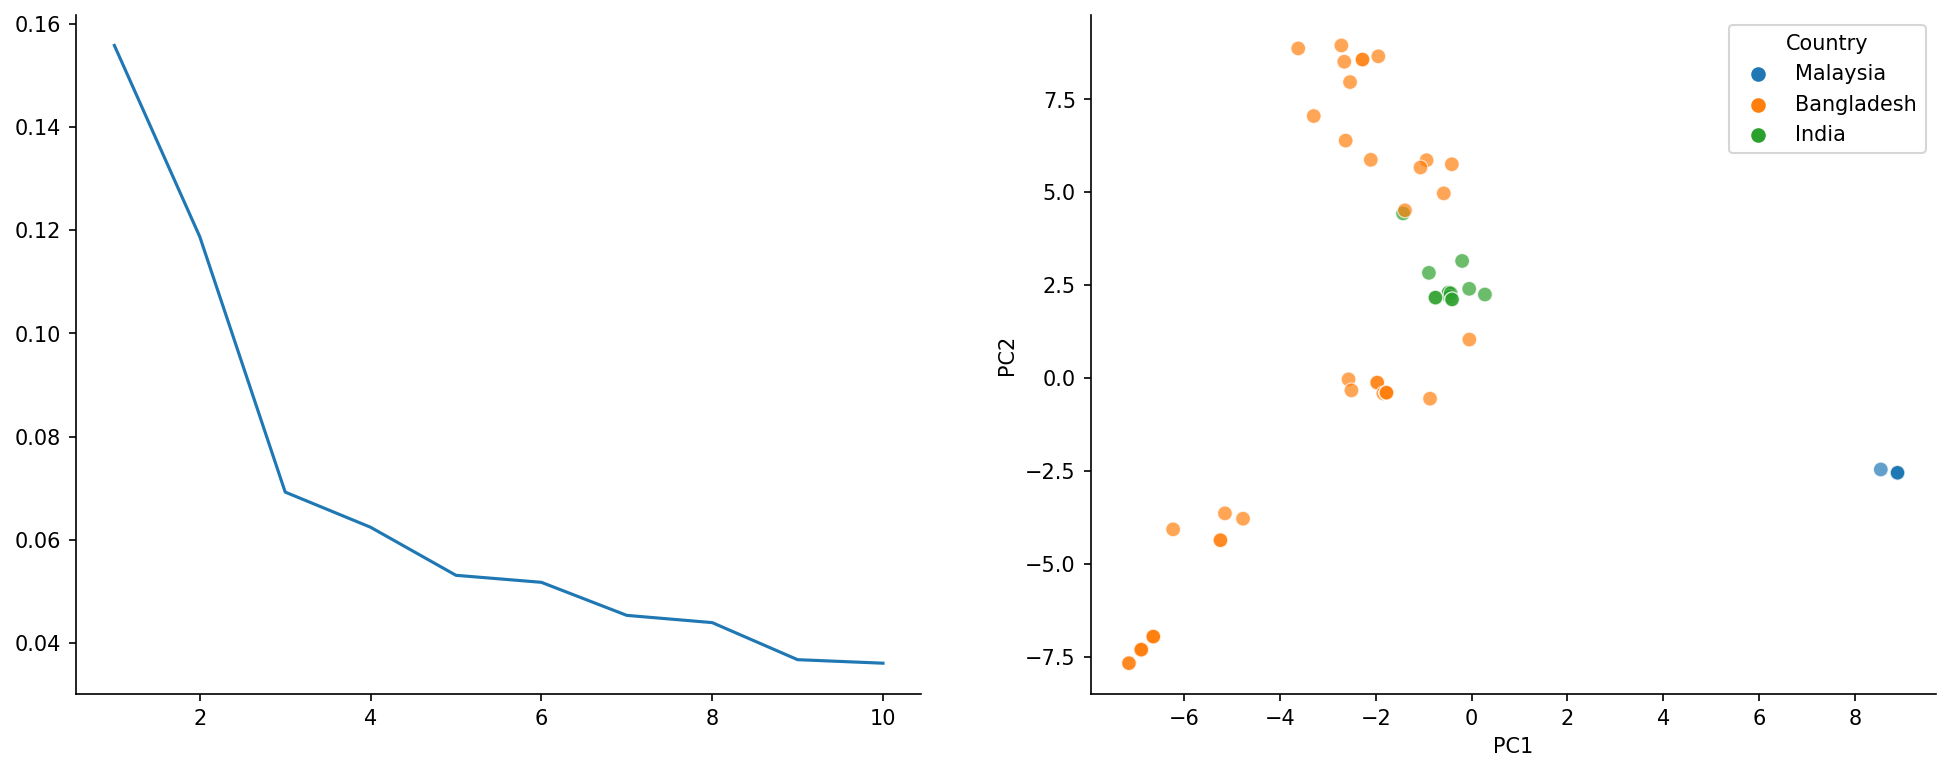

In [13]:
_, pca_df = plot_PCA(input_mat, "Country")

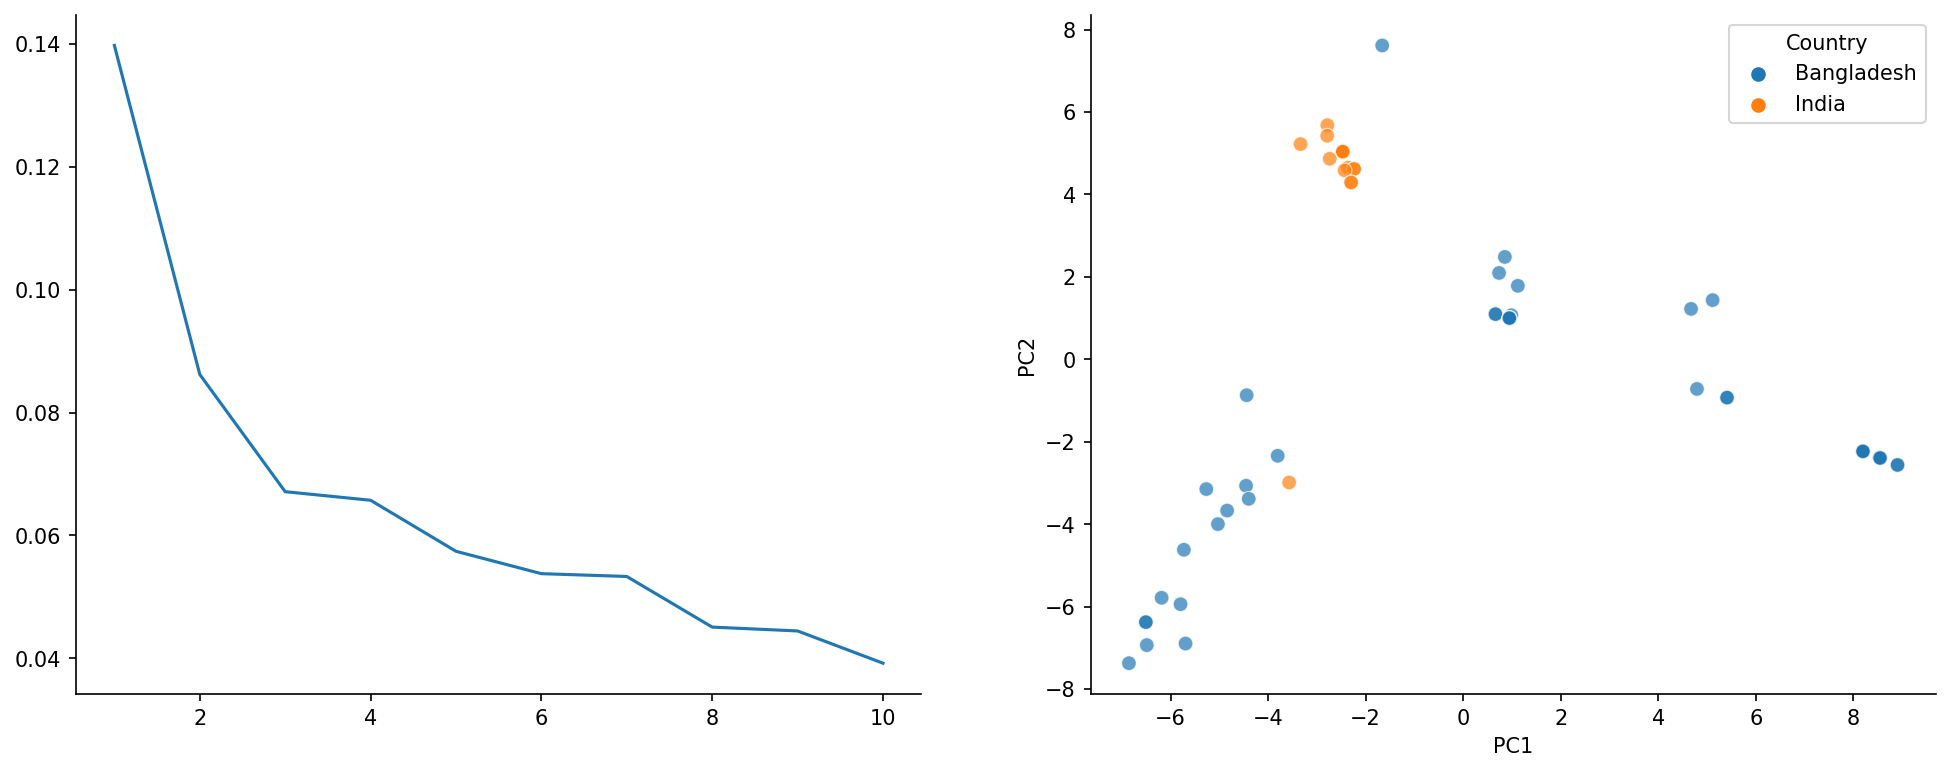

In [14]:
_, pca_df = plot_PCA(input_mat.loc[input_mat.index.isin(metadata.query("Country == 'Bangladesh' | Country == 'India'").ID)],
                     "Country", 2)

# L1/L2-Penalized Logistic Regression, Bangladesh vs. India

## Use `statsmodels` to get p-values

In [39]:
def run_logistic_elasticNet(input_mat, y, scale=True):
    
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(input_mat.values)
    else:
        X = input_mat.values
        
    logistic_cv = LogisticRegressionCV(Cs=np.logspace(-4, 4, 9), 
                                       fit_intercept=True, 
                                       cv=5, 
                                       penalty='elasticnet', 
                                       #scoring='multilabel_confusion_matrix', 
                                       #scoring='precision_recall_fscore_support',
                                       #scoring='log_loss', # cross entropy function for crossentropy
                                       scoring='f1_weighted',
                                       solver='saga', 
                                       max_iter=10000, 
                                       class_weight='balanced', 
                                       l1_ratios=np.linspace(0, 1, 11)
                                      )
    
    logistic_cv.fit(X, y)
    l1_ratio = logistic_cv.l1_ratio_[0]
    alpha = 1/logistic_cv.C_[0]
    print(f"L1 ratio: {l1_ratio}, alpha = {alpha}")
    
    log_reg = LogisticRegression(penalty='elasticnet', 
                                 l1_ratio=logistic_cv.l1_ratio_[0],
                                 C=logistic_cv.C_[0],
                                 fit_intercept=True,
                                 solver='saga',
                                 max_iter=10000,
                                 )
    log_reg.fit(X, y)
    print(f"Score: {round(log_reg.score(X, y), 4)}")
    
    logistic_feat_df = pd.DataFrame(log_reg.coef_).T.rename(columns={0: "coef"})
    logistic_feat_df["feat"] = input_mat.columns
    
    return logistic_feat_df.query("coef != 0")

In [40]:
# India = 0, Bangladesh = 1
india_bgd_df = run_logistic_elasticNet(X_india_bgd, y_india_bgd)

L1 ratio: 0.1, alpha = 100.0
Score: 0.9831


In [63]:
# # get only the features selected by LASSO, then put them into another logistic regression model
# feat_select_india_bgd = X_india_bgd[india_bgd_df["feat"]]

# log_reg_india_bgd = run_logit(feat_select_india_bgd, y_india_bgd)

In [62]:
india_bgd_df

,coef,feat
18,-0.022300,P732
22,-0.077196,P813
44,-0.011142,P942
55,-0.076294,P1099
57,0.084178,P1125
63,-0.076972,P1162
80,-0.076971,P1758
91,-0.076294,P1929
111,-0.060662,G51
164,-0.005712,G1368


In [256]:
metadata.query("P==1").Country.value_counts()

Bangladesh    42
Malaysia      19
India         18
Cambodia       1
Thailand       1
Australia      1
Name: Country, dtype: int64

set()